# Example of spectral integrals: gravity upward continuation 

In the first notebook, we showed how to generate a spectral form of integrals over a single axis. An important application of this procedure is the spectral domain calculation of gravity anomalies, also known as upward continuation. Given a known subsurface density structure $\rho(x,y)$, the vertical component of gravity at the surface (upward continued gravity)  can be written as:

$ \Delta g (x) = 2\pi G \left[ \sum_k e^{ikx} \int_{z_0}^{z_t} \hat \Gamma(k,z)e^{-kz} dz  \right]$

Where:

* $\hat \Gamma$ is the Fourier representation of the density in the horizontal axis

* $e^{-kz}$ is sometimes called the the upward continuation kernel

* for 2D domains, the spectral representation given above assumes the density structure is constant in the 3rd dimension (hence we compare with solutions to a a cylinder not a sphere!)


We will compare this upward continuation proceedure with the analytic solution for gravity above a cylinder. The $g_z$ component of the gravity is:

$$\Delta g_z = \frac{2 \pi G R^2 \Delta \rho z}{(x^2 + z^2)}$$


## Notes

This example is currently set up to illustrate limitations of the spectral gravity approach (upward continuation). Specifially, we choose a domain size / density structure which will leads to a true gravity signal that is different (slightly) at the domain boundaries. The Fourier transform will impose peridodicty on the signal. This means that we cannot correctly capture the (unequal) signal at the domain edges. Windowing and mirroring are two techniques that can reduce this problem.

## A function for spectral integrals.

First let's package up some of the code we used in the first notebook, extending it to also inlcude a "kernel" function.




In [1]:
import underworld as uw
from underworld import function as fn
import glucifer
from scipy.integrate import simps, trapz
import numpy as np
from spectral_tools import *


## Set up problem in Underworld2

In [164]:
lengthScale = 2900e3
# first create a mesh and variable
mesh = uw.mesh.FeMesh_Cartesian(elementType = 'Q1/dQ0', 
                                elementRes=(4*64,64),
                                minCoord    = (-0.7, 1. - 1000e3/lengthScale), 
                                maxCoord    = (0.7, 1.) )


densVar = uw.mesh.MeshVariable(mesh,1)

tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls = mesh.specialSets["MinJ_VertexSet"]
lWalls = mesh.specialSets["MinI_VertexSet"]

In [165]:
(1. - mesh.minCoord[1])

0.3448275862068966

In [166]:
#set up a circle function (cylinders)
radius = 150e3/lengthScale
depth =  400e3/lengthScale
offset= (0., 1 - depth)
coord1 = fn.input() - offset 
circle1 = ( fn.math.dot(coord1,coord1) < radius**2 )

offset2= (0.4, 1 - 1.5*depth)
coord2 = fn.input() - offset2
circle2 = ( fn.math.dot(coord2,coord2) < (0.5*radius)**2 )



In [167]:
densFn = fn.branching.conditional(  ( (circle1,  1.),
                                     (circle2,  1.),
                                              (        True, 0.)   ) )

densVar.data[:] = densFn.evaluate(mesh)


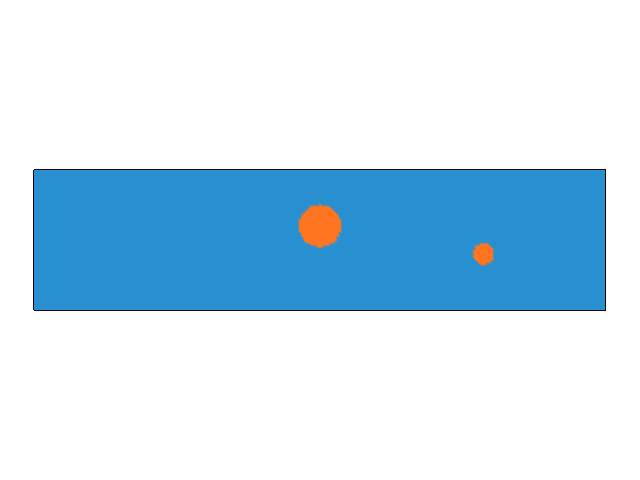

In [168]:
fig = glucifer.Figure(quality=0)
fig.append( glucifer.objects.Surface(mesh, densVar, onMesh=True, colourBar=False) )
fig.show()

## Analytic solution


In [169]:
# dimensional values

G = 6.67e-11         #grav. constant
deltaRho = 50.       #density anomaly kg/m**3

In [170]:
meshXs = mesh.data[mesh.specialSets['MaxJ_VertexSet'].data][:,0]
dimXs = (meshXs - offset[0])*lengthScale
dimDepth = depth*lengthScale
dimrad = radius*lengthScale
grav1 = ((2*np.pi*G*(dimrad)**2*deltaRho))*dimDepth/((dimXs**2 + dimDepth**2))

dimXs2 = (meshXs - offset2[0])*lengthScale
dimDepth2 = 1.5*depth*lengthScale
dimrad2 = 0.5*radius*lengthScale
grav2 = ((2*np.pi*G*(dimrad2)**2*deltaRho))*dimDepth2/((dimXs2**2 + dimDepth2**2))

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


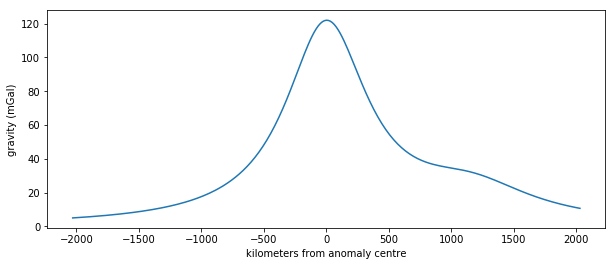

In [171]:
%pylab inline
fig, ax = plt.subplots(figsize=(10, 4))

gravComb = grav1 + grav2

ax.plot(dimXs*1e-3, gravComb *1e5)
ax.set_ylabel('gravity (mGal)')
ax.set_xlabel('kilometers from anomaly centre')

## Upward Continuation using spectral integration
       

In [172]:
densityIntFac = deltaRho*lengthScale
gravitationalFac = 2.*np.pi*G

In [173]:
N = 8
ks = integral_wavenumbers(mesh, N, axisIndex=1)
upContKernelFn = fn.math.exp(-1.*(1. - fn.coord()[1])*ks)

In [174]:
#height = abs(mesh.maxCoord[1] - mesh.minCoord[1])
#average_.evaluate()[0]*densityIntFac*gravitationalFac*1e5*(1./height)

In [175]:
synthFn, coeffs = spectral_integral(mesh, densVar, N=N, axisIndex=1, kernelFn=upContKernelFn, average = True, 
                      integrationType="volume",surfaceIndexSet=None, returnCoeffs=True )

In [176]:
meshxs= mesh.data[mesh.specialSets['MaxJ_VertexSet'].data][:,0]

evals = np.column_stack( (meshxs, np.ones(len(meshxs)) ))
gravFn = synthFn.evaluate(evals )

#Now dimensionalize
gravUw = gravFn*densityIntFac*gravitationalFac

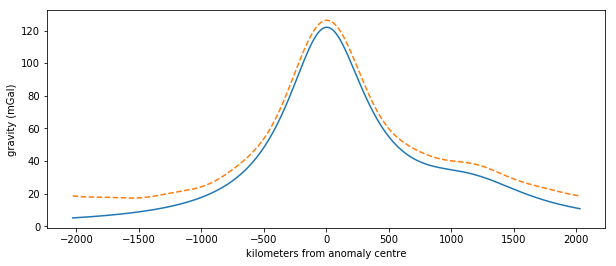

In [177]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dimXs*1e-3, gravComb*1e5)
#ax.plot(dimXs*1e-3, ((gravUw) - ((gravUw)[0]  -gravComb[-1]))  *1e5, ls = '--')
ax.plot(dimXs*1e-3, (gravUw) *1e5, ls = '--')
#ax.plot(dimXs*1e-3, (gravUw - gravUw[0]) *1e5, ls = '--')

ax.set_ylabel('gravity (mGal)')
ax.set_xlabel('kilometers from anomaly centre')

In [178]:
sincfs = coeffs[0].evaluate()
coscfs = coeffs[1].evaluate()

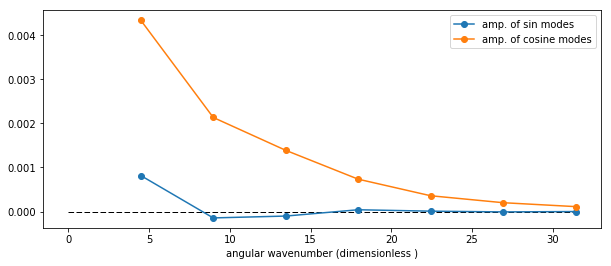

In [179]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(ks,sincfs ,label = 'amp. of sin modes', marker='o'  )
ax.plot(ks,coscfs, label = 'amp. of cosine modes' , marker='o' )
ax.legend()
ax.hlines(0,0, ks[-1], linestyles='--', lw=1. )
ax.set_xlabel('angular wavenumber (dimensionless )')

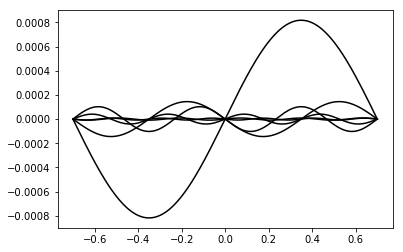

In [193]:
meshxs = mesh.data[tWalls.data][:,0]
width = abs(mesh.maxCoord[0] - mesh.minCoord[0])
sum_ = []
for i in range(len(coscfs) - 1):
    plt.plot(meshxs, sincfs[i]*np.sin(ks[i]*meshxs), c = 'k')
    #plt.plot(meshxs, coscfs[i]*np.cos(ks[i]*meshxs), c = 'r')
    sum_.append ( coscfs[i]*np.cos(ks[i]*meshxs)[0] + sincfs[i]*np.sin(ks[i]*meshxs)[0] )

In [181]:
average_ = uw.utils.Integral(densVar,mesh)
mean = (1./width)*average_.evaluate()[0]

In [182]:
np.cumsum(sum_ ), mean

(array([-0.00434257, -0.00220678, -0.00359677, -0.00286199, -0.00322075,
        -0.00301986]), 0.007534684806036627)

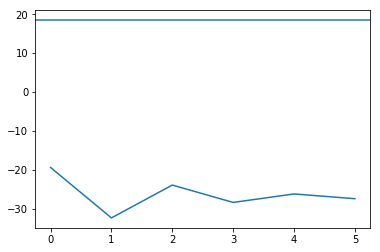

In [183]:
plt.plot( -1.*(np.cumsum(sum_ ) + mean)*densityIntFac*gravitationalFac*1e5)
plt.axhline(gravUw[1]*1e5, 0, 12)

## Upward continuation via numpy FFT

Here we demonstrate the other way of performing the upward continuation - via the Numpy FFT module

* While this is significantly faster, it can only be performed in serial, with a uniform mesh. 

In [184]:



#Build correctly shaped Numpy array represeting node data (density)
density = densVar.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1)
depths = mesh.data[lWalls.data][:,1]

#create the row-wise FFT 
arrayFFT = np.fft.rfft(density) 


N  = density.shape[1]
spacing = (mesh.maxCoord[0] - mesh.minCoord[0])/mesh.elementRes[0]
#Create the wavenumber array - up to the Nyquivst frequancy
kvals = 2.*np.pi*np.fft.rfftfreq(N, d=spacing ) 

#Grab the coordinates of node Xs and Ys
meshxs = mesh.data[tWalls.data][:,0]
meshys = mesh.data[lWalls.data][:,1]

depths = 1. - meshys 

#create the exponent for the upward continuation kernel
expon = np.outer(depths, np.abs(kvals))
#create the upward continuation kernel 
kernelMatrix = np.exp(-1.*expon)

#combine the fourier densiity coefficients and the kernel
Kernel = -1*kernelMatrix*arrayFFT

#integrate over all depths
densSum = simps(Kernel, x = depths, axis=0)

#set the mean value to zero
#mask = kvals == 0
#densSum[mask] = 0

#Do the inverse transform 
gravFFT_ = np.fft.irfft(densSum)
#Dimensionalise
gravNp = gravFFT_*densityIntFac*gravitationalFac

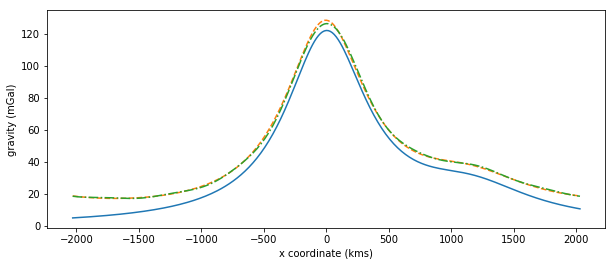

In [185]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(dimXs*1e-3, gravComb*1e5)
ax.plot(dimXs[:-1]*1e-3, ((gravNp) )  *1e5, ls = '--')
ax.plot(dimXs*1e-3, (gravUw) *1e5, ls = '-.')


ax.set_ylabel('gravity (mGal)')
ax.set_xlabel('x coordinate (kms)')